In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [18]:
import os, sys, cv2, pickle
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
from progressbar import ProgressBar
import random, itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, make_scorer, hamming_loss

from keras.utils import to_categorical
from keras.models import Model

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

# Load dataset train

In [19]:
train = pd.read_csv("../data/train.csv", sep=",")
test = pd.read_csv("../data/test.csv", sep=",")
dig_mnist = pd.read_csv("../data/Dig-MNIST.csv", sep=",")
sample_submission = pd.read_csv("../data/sample_submission.csv", sep=",")

# Get Class to create array for model

In [29]:
class Create_Array:
    def __init__(self, data, random_sample, random_state):
        self.random_sample = random_sample
        self.random_state = random_state
        if random_sample == 1: self.data = data
        else:
            train_X, test_X, train_y, test_y = \
            train_test_split(data, data.label, test_size=random_sample, random_state=random_state, stratify=data.label)
            test_X['label'] = test_y
            self.data = test_X.reset_index(drop="index")
    def split_data(self, test_size, to_category):
        self.test_size = test_size
        train_X, test_X, train_y, test_y = \
        train_test_split(self.data.drop(columns="label"), self.data.label, test_size=test_size, random_state=self.random_state, stratify=self.data.label)
        train_X = train_X.reset_index(drop='index')
        self.train_X = self.change_format_X(train_X)
        test_X = test_X.reset_index(drop='index')
        self.test_X = self.change_format_X(test_X)
        train_y = train_y.reset_index(drop='index')
        self.train_y = self.change_format_y(train_y, to_category)
        test_y = test_y.reset_index(drop='index')
        self.test_y = self.change_format_y(test_y, to_category)
    def show_one_image(self, figsize):
        plt.figure(figsize=figsize)
        ind = random.sample(k=1, population=set(self.data.index))
        img = self.data.loc[ind[0]]["pixel0":].values.reshape(28,28)
        plt.imshow(img)
        plt.title("label : {}".format(self.data.loc[ind[0]]["label"]))
        return plt
    def show_multiple_images(self, seed, figsize):
        random.seed(seed)
        num_dict = dict()
        for num in range(10):
            ind = random.sample(k=1, population=set(self.data.loc[self.data.label==num].index))
            num_dict[self.data.label[ind[0]]] = self.data.loc[ind[0]]["pixel0":].values.reshape(28,28)
        plt.figure(figsize=figsize)
        for k,v in num_dict.items():
            plt.subplot(251+k)
            plt.imshow(num_dict[k])
            plt.title("label : {}".format(k))
    def change_format_X(self, data):
        pbar = ProgressBar()
        data_copy = data.copy()
        for k in pbar(data_copy.index):
            if k == 0:
                dat_c = data_copy.loc[0]["pixel0":].values.reshape(28,28)
                dat_c = np.expand_dims(dat_c, axis=2)
                dat_c = np.expand_dims(dat_c, axis=0)
            else:
                k_ = data_copy.loc[k]["pixel0":].values.reshape(28,28)
                k_ = np.expand_dims(k_, axis=2)
                k_ = np.expand_dims(k_, axis=0)
                dat_c = np.concatenate((dat_c, k_), axis=0)
        return dat_c
    def change_format_y(self, data, to_category):
        self.to_category = to_category
        pbar = ProgressBar()
        #data_copy = data.copy()
        y = []
        if to_category:
            for k in pbar(data.index):
                y.append([data.loc[k]])
            y = to_categorical(y)
        else:
            for k in pbar(data.index):
                y.append(data.loc[k])
            y = np.array(y)
        return y

In [30]:
dat = Create_Array(train, 0.1 , 123)

dat_c = dat.data.loc[0]["pixel0":].values.reshape(28,28)
dat_c = np.expand_dims(dat_c, axis=2)
dat_c = np.expand_dims(dat_c, axis=0)
dat_c.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(1, 28, 28, 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


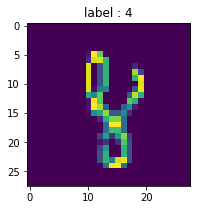

In [31]:
dat = Create_Array(train, 0.1, 123)
_ = dat.show_one_image(figsize=(3,3))

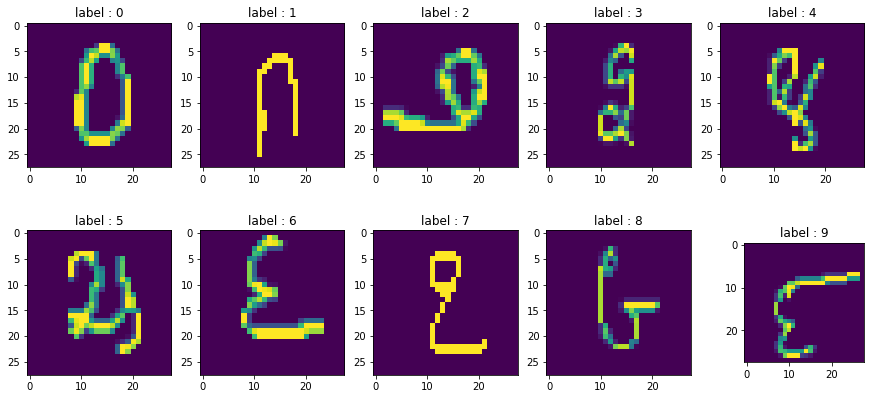

In [32]:
dat.show_multiple_images(figsize=(15,7), seed=654)

In [34]:
dat.split_data(test_size=0.3, to_category=True)

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


In [36]:
dat.train_X.shape

(4200, 28, 28, 1)

In [37]:
dat.train_y.shape

(4200, 10)